This jupyter notebook.
For the CV, it uses `summary.json` files to retrieve the IoU metrics.
For the test, it calculates from the predicted image and label.

Note:
From [`common_question`](https://github.com/MIC-DKFZ/nnUNet/blob/nnunetv1/documentation/common_questions.md#what-postprocessing-is-selected) in the library. `postprocessing.json` have:

```json
    "for_which_classes": [],
```

Therefore, no postprocessing was applied. That is `validation_raw` and `validation_raw_postprocessed` show the same images

In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import glob
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import re
import cv2
from sklearn.metrics import jaccard_score
import pandas as pd
from tqdm import tqdm

# Analyzing single result

`validation_raw/summary.json` contains the metrics for each image

In [2]:
# Import the module
import json

# String with JSON format
# JSON file
f = open ("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/" 
          + "nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw/summary.json", "r")

# Convert JSON string to dictionary
data_dict = json.load(f)

# Mean all folds
Extracting Jaccard/IoU (Intersection over Union) metric

In [3]:
# Import the module
import json
import pandas as pd
# String with JSON format
# JSON file

l_columns = ["IoU class 0", "IoU class 1"]
pd_mean = pd.DataFrame(columns = l_columns)

for i in range(5):
    f = open ("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/"
              +f"nnUNetTrainerV2__nnUNetPlansv2.1/fold_{i}/validation_raw/summary.json", "r")

    # Convert JSON string to dictionary
    data_dict = json.load(f)
    
    jaccard_0 = data_dict["results"]["mean"]["0"]["Jaccard"]
    jaccard_1 = data_dict["results"]["mean"]["1"]["Jaccard"]
    
    pd_mean.loc[i] = [jaccard_0, jaccard_1]

In [4]:
pd_mean.to_csv("../../results/processed_results/iou_mean.csv")

# Individual values

In [5]:
# Import the module
import json
import pandas as pd
# String with JSON format
# JSON file

l_columns = ["fold","index","IoU class 0", "IoU class 1"]
df_all = pd.DataFrame(columns = l_columns)

for i in range(5):
    f = open ("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/"
              +f"nnUNetTrainerV2__nnUNetPlansv2.1/fold_{i}/validation_raw/summary.json", "r")

    # Convert JSON string to dictionary
    data_dict = json.load(f)
#     print(f"fold = {i}", len(data_dict["results"]["all"]))
    for element in data_dict["results"]["all"]:
        fold = i
#         print(element["test"])
        index = int(os.path.basename(element["test"])[:4])
        jaccard_0 = element["0"]["Jaccard"]
        jaccard_1 = element["1"]["Jaccard"]
        data_temp = {"fold": [fold],
                     "index": [index],
                     "IoU class 0": [jaccard_0],
                     "IoU class 1": [jaccard_1]}
        df_temp = pd.DataFrame(data_temp)
#         print(f"fold {i} index {index}")
        df_all = pd.concat([df_all, df_temp], ignore_index = True)

In [6]:
df_all.to_csv("../../results/processed_results/iou_all.csv")

In [7]:
df_all.head()

,fold,index,IoU class 0,IoU class 1
0,0,2,0.993154,0.913077
1,0,3,0.989452,0.883567
2,0,9,0.994686,0.934374
3,0,18,0.995009,0.857699
4,0,19,0.993333,0.880295


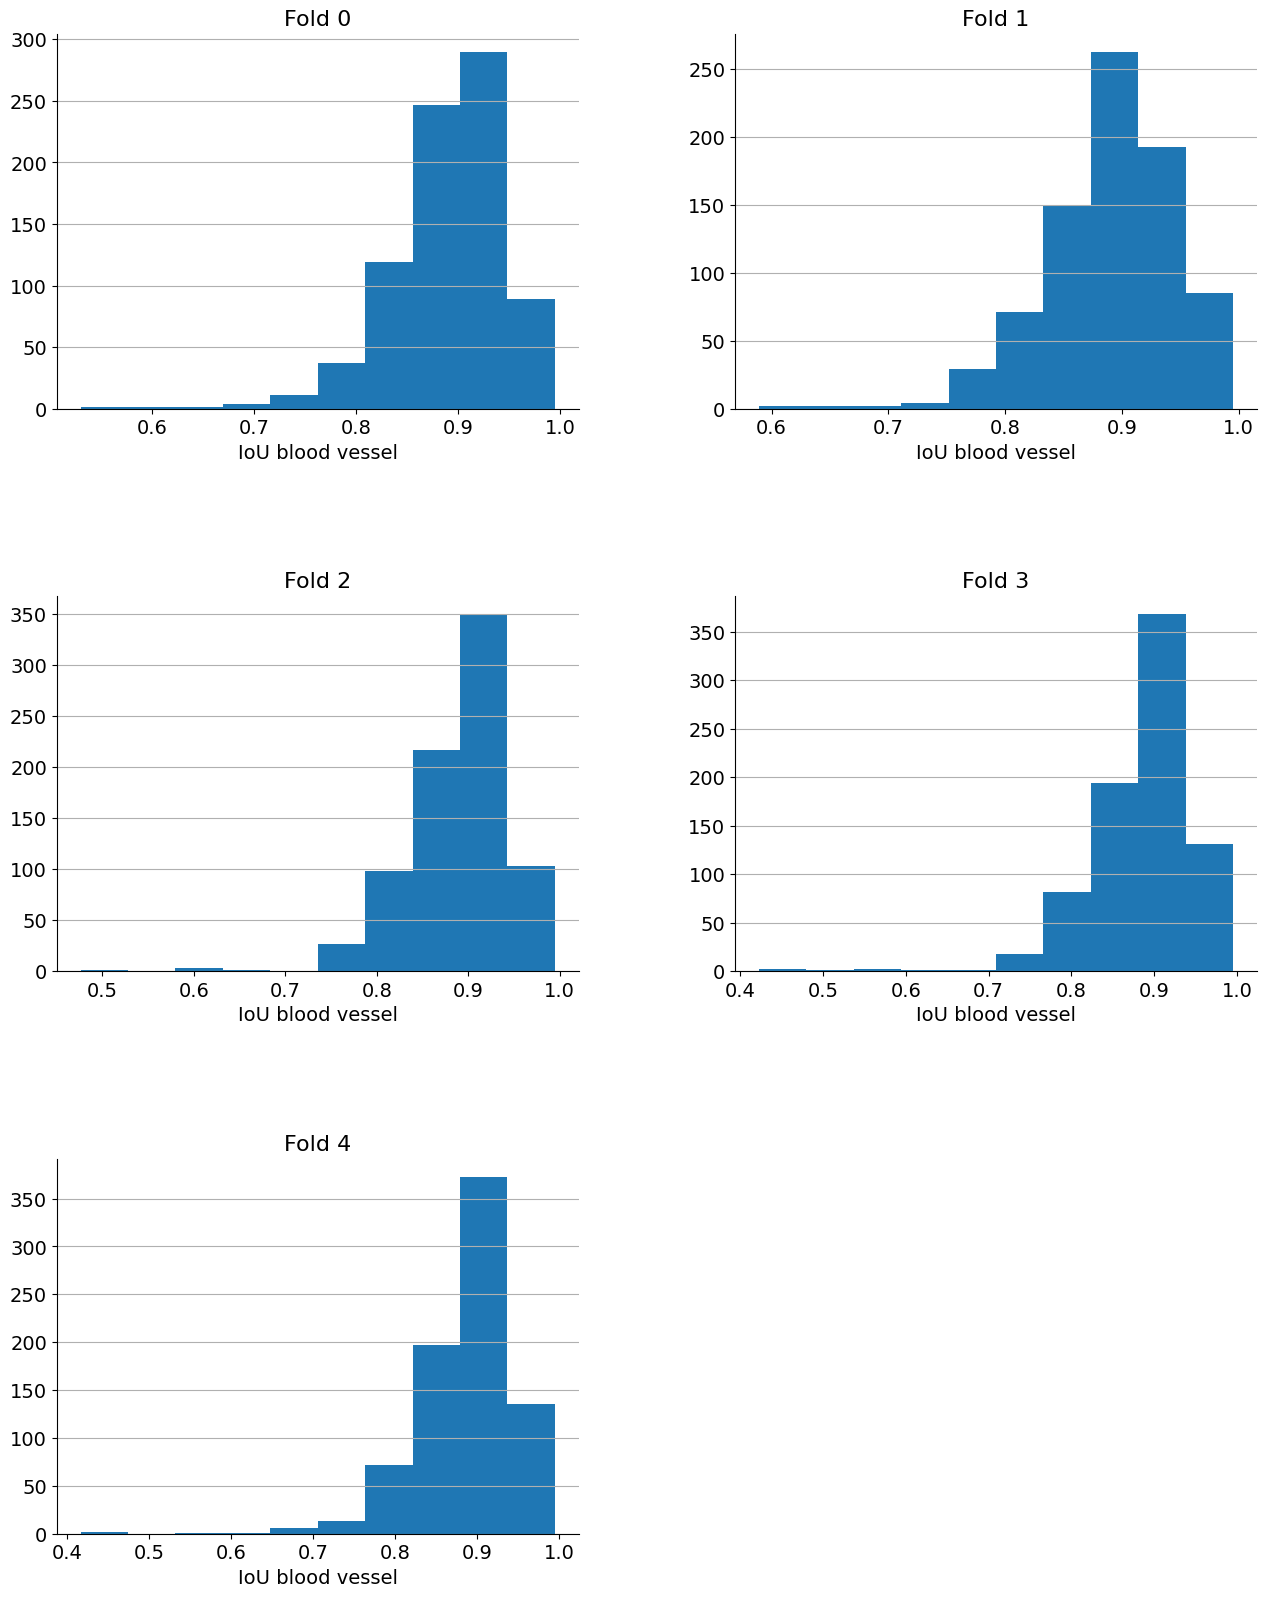

In [8]:
a_ax = df_all.hist(column="IoU class 1", by = "fold", figsize = (15,20))
fig = a_ax[0,0].get_figure()

for i, ax in enumerate(a_ax.ravel()):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("IoU blood vessel", fontsize = 14)
    ax.xaxis.set_tick_params(labelsize=14, rotation=0)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_title(f"Fold {i}", fontsize = 16)
    ax.grid(which = "major", axis = "y")

path_directory = "../../results/processed_results/histogram"
    
filename = "histogram_IoU.png"
file_path = os.path.join(path_directory, filename)
        
fig.savefig(file_path, dpi=350)

In [9]:
df_all["IoU class 1"].dtypes

dtype('float64')

In [10]:
df_all.dtypes

fold            object
index           object
IoU class 0    float64
IoU class 1    float64
dtype: object

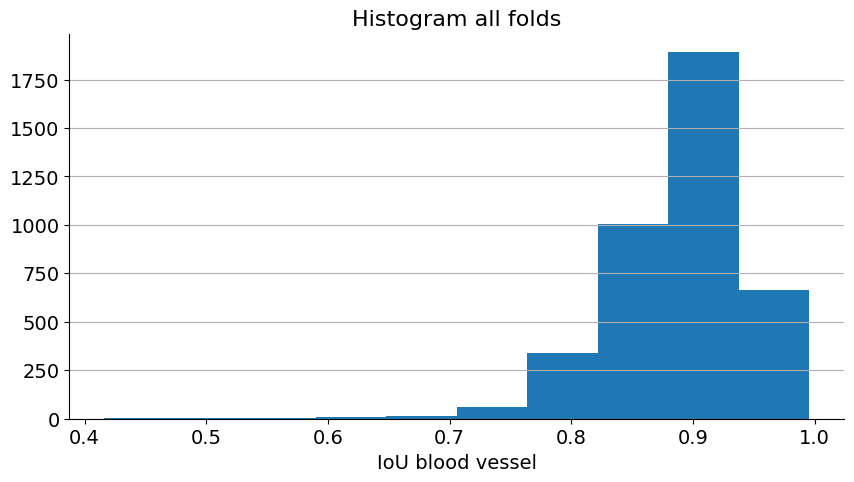

In [11]:
df_all = df_all.astype({"IoU class 1": float})

a_ax = df_all.hist(column="IoU class 1", figsize = (10,5))

ax = a_ax[0,0]
fig = ax.get_figure()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("IoU blood vessel", fontsize = 14)
ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title(f"Histogram all folds", fontsize = 16)
ax.grid(which = "major", axis = "x")

path_directory = "../../results/processed_results/histogram"
    
filename = "histogram_IoU_all.png"
file_path = os.path.join(path_directory, filename)
        
fig.savefig(file_path, dpi=350)

In [12]:
a_ax[0][0]

<AxesSubplot: title={'center': 'Histogram all folds'}, xlabel='IoU blood vessel'>

In [13]:
a_ax

array([[<AxesSubplot: title={'center': 'Histogram all folds'}, xlabel='IoU blood vessel'>]],
      dtype=object)

In [14]:
df_all.head()

,fold,index,IoU class 0,IoU class 1
0,0,2,0.993154,0.913077
1,0,3,0.989452,0.883567
2,0,9,0.994686,0.934374
3,0,18,0.995009,0.857699
4,0,19,0.993333,0.880295


In [15]:
df_all.columns

Index(['fold', 'index', 'IoU class 0', 'IoU class 1'], dtype='object')

In [16]:
df_all.groupby(by="fold").mean()

/tmp/ipykernel_66910/2682154546.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(by="fold").mean()


,IoU class 0,IoU class 1
fold,,
0,0.991388,0.892554
1,0.992069,0.891172
2,0.991425,0.891180
3,0.991751,0.888162
4,0.991676,0.888416


In [17]:
df_all_mean = df_all.groupby(by="fold").mean()
df_all_mean.to_csv("../../results/processed_results/iou_all_mean.csv")

/tmp/ipykernel_66910/336028902.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all_mean = df_all.groupby(by="fold").mean()


# Test: Manual calculation

Prediction results do not provide the metrics, therefore they need to be calculated manually from the predicted image and the label

In [19]:
l_truth = []
l_predicted = []

path_dataset = "/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3"
path_output = "/home/pcallec/nnUNet_blood-vessel/results/processed_results/"
predicted_dir = "/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3"

test_predicted_img_paths = glob.glob(predicted_dir + "/*.nii.gz")
test_predicted_img_paths.sort()

l_columns = ["image_index","iou_background", "iou_bloodvessel"]
df_all = pd.DataFrame(columns=l_columns)

for test_predicted_path in tqdm(test_predicted_img_paths):
    # TODO
    # Extract number from name to put in name for superimposed image

    re_number = re.compile(r'(?<=/)[0-9]{4}')
    img_number = re_number.search(test_predicted_path).group(0)
    path_label_truth = os.path.join(path_dataset, f"{img_number}_labeled_1ch.png")
    path_image = os.path.join(path_dataset, f"{img_number}.png")

    # print("img_number = ", img_number)
    # print(path_image)
    # print(path_label_truth)

    # Read image
    img_input_pillow = Image.open(path_image)
    a_img_input_pillow = np.array(img_input_pillow)
    # print("a_img_input_pillow.shape = ", a_img_input_pillow.shape)

    # Read label
    img_label_pillow = Image.open(path_label_truth)
    a_img_label_pillow = np.array(img_label_pillow)
    # print("a_img_label_pillow.shape = ", a_img_label_pillow.shape)

    # Changing values of label to 0 and 1
    np.place(a_img_label_pillow, a_img_label_pillow == 53, 0)
    np.place(a_img_label_pillow, a_img_label_pillow == 91, 1)

    # Read prediction
#     a_img_pillow = np.where(a_img_pillow ==255, 1, a_img_pillow)
    img = nib.load(test_predicted_path)
    epi_img_data = img.get_fdata()
    mask_cv2 = np.uint8(epi_img_data[:,:,0].T)
#     plt.imshow(mask_cv2_color, interpolation='nearest')


    iou_background_temp, iou_bloodvessel_temp = jaccard_score(mask_cv2.ravel(), a_img_label_pillow.ravel(), average=None)
    data = [{"image_index": img_number, 
            "iou_background": iou_background_temp,
            "iou_bloodvessel": iou_bloodvessel_temp}]
    df_temp = pd.DataFrame(data)
    
    df_all = pd.concat([df_all, df_temp], ignore_index=True)
#     break

100%|██████████| 1000/1000 [00:27<00:00, 35.82it/s]


In [21]:
df_all.head()

,image_index,iou_background,iou_bloodvessel
0,0013,0.988872,0.886246
1,0021,0.995930,0.932365
2,0026,0.992013,0.913521
3,0028,0.994334,0.929027
4,0029,0.991983,0.910866


In [51]:
df_all.mean()

image_index             inf
iou_background     0.991627
iou_bloodvessel    0.891726
dtype: float64

In [22]:
df_all.to_csv("../../results/processed_results/iou_all_test.csv")

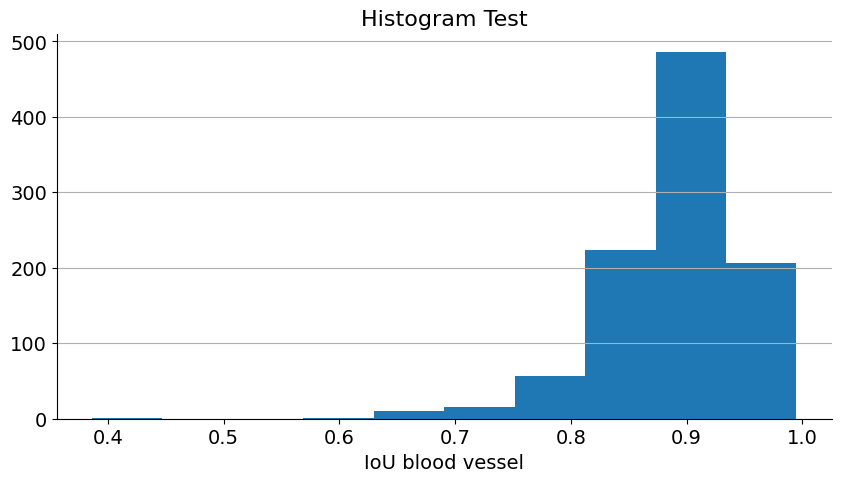

In [23]:
a_ax = df_all.hist(column="iou_bloodvessel", figsize = (10,5))

ax = a_ax[0,0]
fig = ax.get_figure()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("IoU blood vessel", fontsize = 14)
ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title(f"Histogram Test", fontsize = 16)
ax.grid(which = "major", axis = "x")

path_directory = "../../results/processed_results/histogram"
    
filename = "histogram_IoU_all_test.png"
file_path = os.path.join(path_directory, filename)
        
fig.savefig(file_path, dpi=350)